# November 2021 Grand Banks Drifter Deployment Plan

We plan to deploy several drifters at AZMP stations during the November 2021 cruise. This document outline the drifter inventory and ideal deployment locations.

## Goals
* Create an inventory of drifter data on the Grand Banks for model evaluation
* Collect observed wave data on the Grand Banks for comparison with wave models
* Collect observations of veritcal current shear in upper 15m of Grand Banks
* Collect observations of surface temperatures on Grand Bank
* Compare drift characteristics between Stokes and Oskers


## Drifter Inventory
| Name    | Type    | Quantity | Data collected             |
|---------|---------|----------|----------------------------|
| Osker   | Surface | 4        | Position                   |
| Stokes  | Surface | 7        | Position/Temperature       |
| iSVP    | Drogued | 5        | Position/Temperature       |
| Spotter | Wave    | 1        | Position/Temperature/Waves | 


## Deployment locations

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
lat_min=40
lon_min=-60
lat_max=55
lon_max=-40

In [3]:
# Glorys climatology
f='/home/soontiensn/remote2/hank/climatology/glorys12/monthly/mercatorglorys12v1_gl12_mean_11_199301-201812.nc'
d = xr.open_dataset(f)
dsel = d.isel(depth=0,time=0).sel(latitude=slice(lat_min,lat_max), longitude=slice(lon_min, lon_max)) 
uvel = dsel.uo.values
vvel = dsel.vo.values
lat = dsel.latitude.values
lon = dsel.longitude.values
lon, lat = np.meshgrid(lon, lat)

In [4]:
# etopo file
ef = '/home/soontiensn/data/ocn-nav/ETOPO1_Bed_g_gmt4.grd'
etopo = xr.open_dataset(ef)
esel = etopo.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

In [5]:
def plot_quivers(ax, xvel,yvel,lat,lon,st=10):
    bmap = Basemap(projection='merc',llcrnrlon=lon_min, urcrnrlon=lon_max,
                   llcrnrlat=lat_min,urcrnrlat=lat_max, ax=ax,resolution='i')
    bmap.drawcoastlines()
    bmap.fillcontinents(color='grey',)
    bmap.drawparallels(np.arange(lat_min, lat_max, 5.))
    bmap.drawmeridians(np.arange(lon_min, lon_max,5.))
    mag = np.sqrt(xvel**2+yvel**2)
    mesh=bmap.pcolormesh(lon,lat,mag,latlon=True,vmin=0,vmax=1,cmap='YlGnBu_r')
    q=bmap.quiver(lon[::st,::st],lat[::st,::st],xvel[::st,::st],yvel[::st,::st],latlon=True,scale=10,color='lightgrey')
    ax.quiverkey(q,0.05,0.2,0.5,'0.5 m/s',color='lightgrey')
    cbar=plt.colorbar(mesh, ax=ax)
    cbar.set_label('speed [m/s]')
    return bmap

In [6]:
def plot_transects(bmap,ax,transects):
    for transect in transects:
        lons = np.array([transects[transect]['start'][0],
                         transects[transect]['end'][0]])
        lats = np.array([transects[transect]['start'][1],
                         transects[transect]['end'][1]])
        x,y = bmap(lons, lats)
        bmap.plot(x,y,'-r')

In [7]:
def plot_stations(bmap,ax,stations):
    for station in stations:
        lon = stations[station][0]
        lat = stations[station][1]
        x,y = bmap(lon, lat)
        if 'FC' in station:
            marker='o'
        else:
            marker = 's'
        bmap.plot(x,y,marker, label=station)

In [8]:
def plot_bathymetry(bmap, ax, etopo):
    lons = etopo.x.values
    lats = etopo.y.values
    lons, lats = np.meshgrid(lons,lats)
    x, y = bmap(lons, lats)
    bathy = etopo.z.values
    levels = [-500, -100,]
    CS = bmap.contour(x,y,bathy,levels, linestyles='solid', linewidth=0.1,colors='black')
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=12)

In [9]:
transects = {
    'FC': {'start':[ -52.8316666666667, 47],
           'end': [-42, 47]},
    'SEGB': {'start': [-52.9333333333333, 46.5833333333333],
             'end': [-48.6666666666667, 41.3333333333333]}
}
stations = {
    'FC-06 \n  1 Osker \n  1 Stokes \n  1 iSVP': [-51.485,47],
    'FC-09 \n  1 Osker \n  1 Stokes \n  1 iSVP': [-50,47],
    'FC-10 \n  1 Osker \n  1 Stokes \n  1 iSVP \n  1 Spotter':[-49.1166666666667,47],
    'FC-11 \n  1 Osker \n  1 Stokes \n  1 iSVP': [-48.6166666666667,47],
    'FC-25 \n  1 Stokes \n  1 iSVP':[-44.9883333333333,47],
    'SEGB-08 \n  1 Stokes': [-51.7,45.095],
    'SEGB-12 \n  1 Stokes': [-50.5166666666667,43.6333333333333]
}

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'linewidth'
  


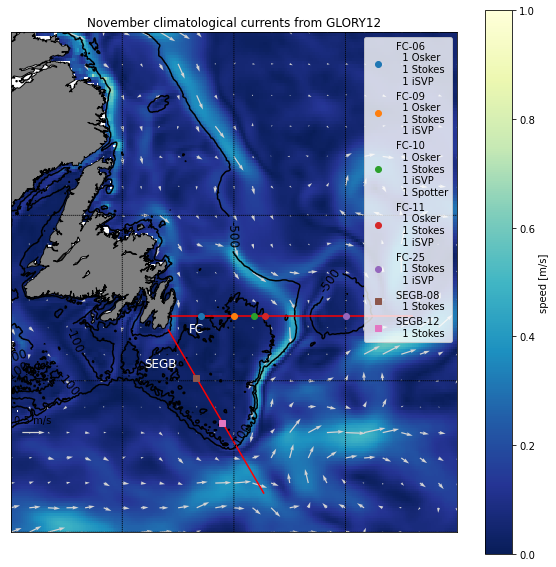

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
bmap = plot_quivers(ax,uvel,vvel,lat, lon)
plot_transects(bmap, ax, transects)
plot_stations(bmap, ax, stations)
plot_bathymetry(bmap, ax, esel)
ax.text(0.4,0.4, 'FC', fontsize=12,color='w', transform=ax.transAxes)
ax.text(0.3,0.33, 'SEGB', fontsize=12,color='w', transform=ax.transAxes)
ax.set_title('November climatological currents from GLORY12')
ax.legend()